In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')

print("Imported the modules.")

Imported the modules.


In [2]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

In [6]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent latitude.
latitude = tf.feature_column.numeric_column("latitude")
feature_columns.append(latitude)

# Create a numerical feature column to represent longitude.
longitude = tf.feature_column.numeric_column("longitude")
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

In [9]:
def create_model(my_learning_rate, feature_layer):
    """Create and compile a simple linear regression model."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(feature_layer)

    # Add one linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

    # Construct the layers into a model that TensorFlow can execute.
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model           


def train_model(model, dataset, epochs, batch_size, label_name):
    """Feed a dataset into the model in order to train it."""

    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the mean absolute error for each epoch.
    hist = pd.DataFrame(history.history)
    rmse = hist["root_mean_squared_error"]

    return epochs, rmse   


def plot_the_loss_curve(epochs, rmse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
    plt.show()  

    print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Train on 17000 samples
Epoch 1/30
17000/17000 [==============================] - 1s 32us/sample - loss: 16283.6565 - root_mean_squared_error: 127.6075
Epoch 2/30
17000/17000 [==============================] - 0s 10us/sample - loss: 13446.4918 - root_mean_squared_error: 115.9590
Epoch 3/30
17000/17000 [==============================] - 0s 10us/sample - loss: 13389.1272 - root_mean_squared_error: 115.7114
Epoch 4/30
17000/17000 [==============================] - 0s 11us/sample - loss: 13369.3261 - root_mean_squared_error: 115.6258
Epoch 5/30
17000/17000 [==============================] - 0s 10us/sample - loss: 13320.0740 - root_mean_squared_error: 115.4126
Epoch 6/30
17000/17000 [==============================] - 0s 10us/sample - loss: 13272.9849 - root_mean_squared_error: 115.2085
Epoch 7/30
17000/17000 [==============================] - 0s 10us/sample - loss: 13230.9032 - root_mean_squared_error: 115.0257
Epoch 8/30
17000/17000 [==============================] - 0s 10us/sample - loss: 

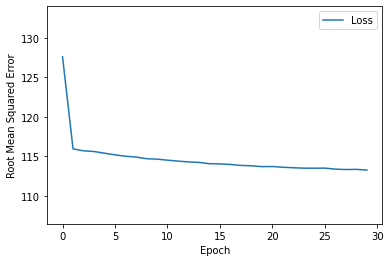

Defined the create_model, train_model, and plot_the_loss_curve functions.

: Evaluate the new model against the test set:
3000/3000 [==============================] - 0s 26us/sample - loss: 12179.9767 - root_mean_squared_error: 110.3629


[12179.976725260416, 110.36294]

In [10]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [11]:
resolution_in_degrees = 1.0 

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), 
                                     int(max(train_df['latitude'])), 
                                     resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, 
                                               latitude_boundaries)
feature_columns.append(latitude)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                      int(max(train_df['longitude'])), 
                                      resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
buckets_feature_layer = layers.DenseFeatures(feature_columns)

Train on 17000 samples
Epoch 1/35
17000/17000 [==============================] - 0s 25us/sample - loss: 52002.8751 - root_mean_squared_error: 228.0414
Epoch 2/35
17000/17000 [==============================] - 0s 10us/sample - loss: 44640.2877 - root_mean_squared_error: 211.2825
Epoch 3/35
17000/17000 [==============================] - 0s 10us/sample - loss: 38054.5101 - root_mean_squared_error: 195.0756
Epoch 4/35
17000/17000 [==============================] - 0s 11us/sample - loss: 32244.8136 - root_mean_squared_error: 179.5684
Epoch 5/35
17000/17000 [==============================] - 0s 10us/sample - loss: 27219.8204 - root_mean_squared_error: 164.9843
Epoch 6/35
17000/17000 [==============================] - ETA: 0s - loss: 23177.2027 - root_mean_squared_error: 152.240 - 0s 10us/sample - loss: 22963.5801 - root_mean_squared_error: 151.5374
Epoch 7/35
17000/17000 [==============================] - 0s 10us/sample - loss: 19456.4766 - root_mean_squared_error: 139.4865
Epoch 8/35
17000/

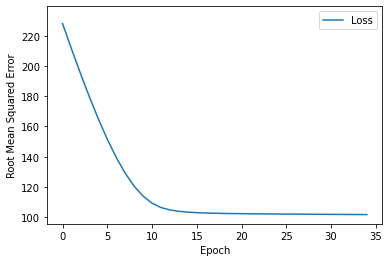

Defined the create_model, train_model, and plot_the_loss_curve functions.

: Evaluate the new model against the test set:
3000/3000 [==============================] - 0s 35us/sample - loss: 10198.2822 - root_mean_squared_error: 100.9865


[10198.282161458334, 100.98654]

In [15]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the buckets_feature_layer.
my_model = create_model(learning_rate, buckets_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [26]:
resolution_in_degrees = .5

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_cross_feature_layer = layers.DenseFeatures(feature_columns)

Train on 17000 samples
Epoch 1/35
17000/17000 [==============================] - 0s 29us/sample - loss: 53607.3500 - root_mean_squared_error: 231.5326
Epoch 2/35
17000/17000 [==============================] - 0s 12us/sample - loss: 48709.7467 - root_mean_squared_error: 220.7028
Epoch 3/35
17000/17000 [==============================] - 0s 12us/sample - loss: 44144.7784 - root_mean_squared_error: 210.1065
Epoch 4/35
17000/17000 [==============================] - 0s 12us/sample - loss: 39882.2409 - root_mean_squared_error: 199.7054
Epoch 5/35
17000/17000 [==============================] - 0s 14us/sample - loss: 35955.1461 - root_mean_squared_error: 189.61840s - loss: 36451.0687 - root_mean_squared_error: 190.92
Epoch 6/35
17000/17000 [==============================] - 0s 13us/sample - loss: 32328.1169 - root_mean_squared_error: 179.8002
Epoch 7/35
17000/17000 [==============================] - 0s 12us/sample - loss: 29024.0934 - root_mean_squared_error: 170.3646
Epoch 8/35
17000/17000 [==

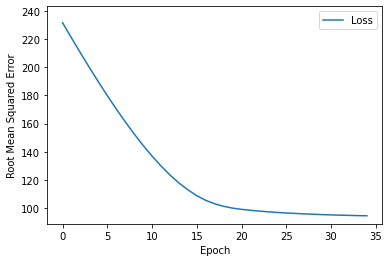

Defined the create_model, train_model, and plot_the_loss_curve functions.

: Evaluate the new model against the test set:
3000/3000 [==============================] - 0s 44us/sample - loss: 9011.1590 - root_mean_squared_error: 94.9271


[9011.158951822918, 94.927124]

In [27]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, feature_cross_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)